<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Introduction-" data-toc-modified-id="1.-Introduction--1">1. Introduction </a></span></li><li><span><a href="#Complaint-Length-" data-toc-modified-id="Complaint-Length--2">Complaint Length </a></span></li><li><span><a href="#Most-Common-Words" data-toc-modified-id="Most-Common-Words-3">Most Common Words</a></span></li><li><span><a href="#Most-Common-Word-Pairs" data-toc-modified-id="Most-Common-Word-Pairs-4">Most Common Word Pairs</a></span></li></ul></div>

In [1]:
# Styling notebookb
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm
from wordcloud import WordCloud
from src.fetch_data import fetch_data
from src.config import app_key

<h1>1. Introduction </h1>

<div class="description">

The purpose of this project is to train a NLP multi-class classification model on building complaints received by the City of San Francisco to effectively predict which division a complaint needs to be assigned to. We will explore a variety of approaches to solving this problem using Tensorflow, Scikit-Learn, Spacy, and NLTK. 

In this exploratory notebook we will load the raw data from the City of San Francisco's API and analyze it to get a better idea of the problem we are solving. We will also do some simple preprocessing to prepare the text for the clean_data notebook which is where the text will be normalized and then tokenized using a Tensorflow tokenizer before it is ready to be used in machine learning. 
    
</div>

<div class="description">

First we run our fetch_data function to fetch the dataset from San Francisco's SODA API and save it to our /data/ directory.   
    
* Note that you need a SODA app key to access the API, here I'm passing mine from my config file.
    
</div>

In [3]:
fetch_data(app_key)

In [22]:
#load data into a Panda's dataframe
working_dir = os.getcwd()
data_path = os.path.dirname(working_dir) + '/data/'
df = pd.read_csv(data_path + 'raw_data.csv', usecols=['complaint_description', 'assigned_division'])

In [23]:
df.head()

,complaint_description,assigned_division
0,1005 larkin --- caller reports construction go...,Building Inspection Division
1,Hallway ceiling leak (water enter into the uni...,Housing Inspection Services
2,Social worker called report client perfecta bu...,Housing Inspection Services
3,Needs to renew boiler permit for permit no 947...,Plumbing Inspection Division
4,While performing a field inspection for a mech...,Plumbing Inspection Division


In [24]:
#view the shape of our dataset
df.shape

(267845, 2)

In [25]:
#determine how many duplicate entries there are
df.duplicated().sum()

83988

In [26]:
#drop duplicates
df.drop_duplicates(inplace = True)

In [27]:
print("Duplicated: ", df.duplicated().sum())
print("Shape: ", df.shape)

Duplicated:  0
Shape:  (183857, 2)


In [28]:
#ensure datatypes are correct
df.dtypes

complaint_description    object
assigned_division        object
dtype: object

In [29]:
#determine how many complaints there are for each category
df.assigned_division.value_counts()

Housing Inspection Services       86858
Building Inspection Division      63360
Plumbing Inspection Division      16246
Code Enforcement Section          10689
Electrical Inspection Division     5524
Disabled Access Division           1112
Help Desk / Technical Services       32
Department of Bldg Inspection        11
Other/Outside Agency                  9
Department of City Planning           4
Major Plan Check Division             1
Seismic Safety Section                1
Central Permit Bureau                 1
Department of Public Health           1
Name: assigned_division, dtype: int64

<div class="description">
Clearly we are dealing with an imbalanced data set, with virtually half of the complaints belonging to Housing Inspection Services. We will explore different techniques later on to deal with this imbalance like oversampling and using class weights in Tensorflow. 
    
<br>    
    
We will remove the categories that don't have at least 1000 complaints, focusing on the six most common divisions as the rest are unconsequential.
    
</div>

In [30]:
df = df.groupby("assigned_division").filter(lambda x: len(x) > 1000)

In [31]:
#examine a sample of complaint descriptions
display(df.complaint_description.sample(10))

95575     Construction is going on in the basement w/out...
252466    Customer stated the rooms does not have window...
260902    The entire building has been out of water for ...
266726    Date last observed: 29-jan-18;    time last ob...
24224     Needs to renew boiler permit for permit no 101...
56103     No heat in bldg. since january.  tenants using...
4031      Needs to renew boiler permit for permit no 931...
124360    Elevator is not working, toilet in #407 does n...
17132     Date last observed: 02-aug-21;    identity of ...
851       Vacant commercial storefront - 9251389filthy s...
Name: complaint_description, dtype: object

In [32]:
#check for null values
df.isna().sum()

complaint_description    5
assigned_division        0
dtype: int64

In [33]:
#drop any rows that contain null values
df.dropna(inplace = True)

In [34]:
#find the length of the longest complaint
df["complaint_description"].str.len().max()

1000

<h1>Complaint Length </h1>

COMPLAINT LENGTH STATISTICS:
Mean Complaint Length:  148.40271732033256
Min Complaint Length:  1
Max Complaint Length:  1000


Text(0, 0.5, 'Count')

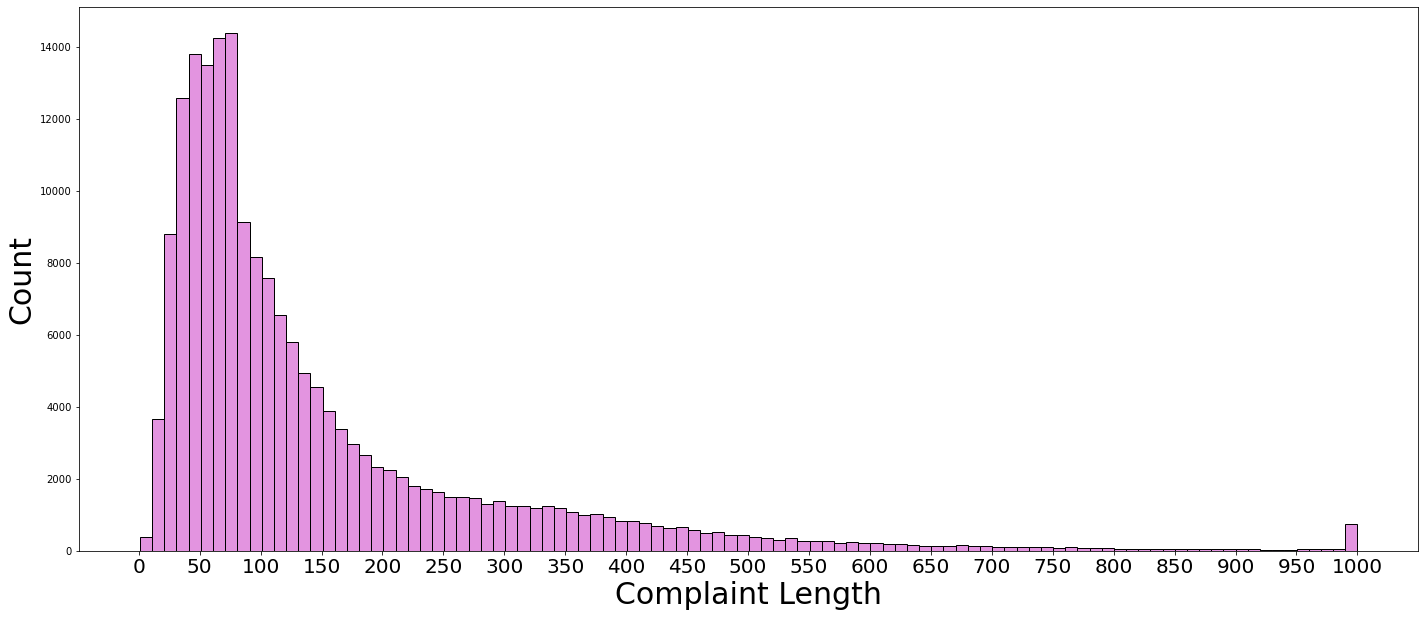

In [41]:
sample = df.copy()
sample['complaint_length'] = sample['complaint_description'].apply(len)
print("COMPLAINT LENGTH STATISTICS:")
print("Mean Complaint Length: ", sample['complaint_length'].mean())
print("Min Complaint Length: ", sample['complaint_length'].min())
print("Max Complaint Length: ", sample['complaint_length'].max())

#plot a histogram of the complaint lengths
fig, ax = plt.subplots(figsize=(24,10))
ax = sns.histplot(data = sample, x='complaint_length', bins = 100, color = "orchid")
xticks = plt.xticks(np.arange(0, 1001, 50.0))
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel('Complaint Length', fontsize = 30)
ax.set_ylabel('Count', fontsize = 30)



<div class="description">
We can see most complaints are around 40 to 80 words long, with a steep decline after 100 words. 
The distribution is cleary positively skewed and we also can confirm that complaints are getting cut off at 1000 characters in length, as evident from the spike at 1,000.
</div>

<h1>Most Common Words</h1>

<div class="description">
 Here we will create a word cloud to display the most common words found across the building complaints.
</div>

(-0.5, 2399.5, 999.5, -0.5)

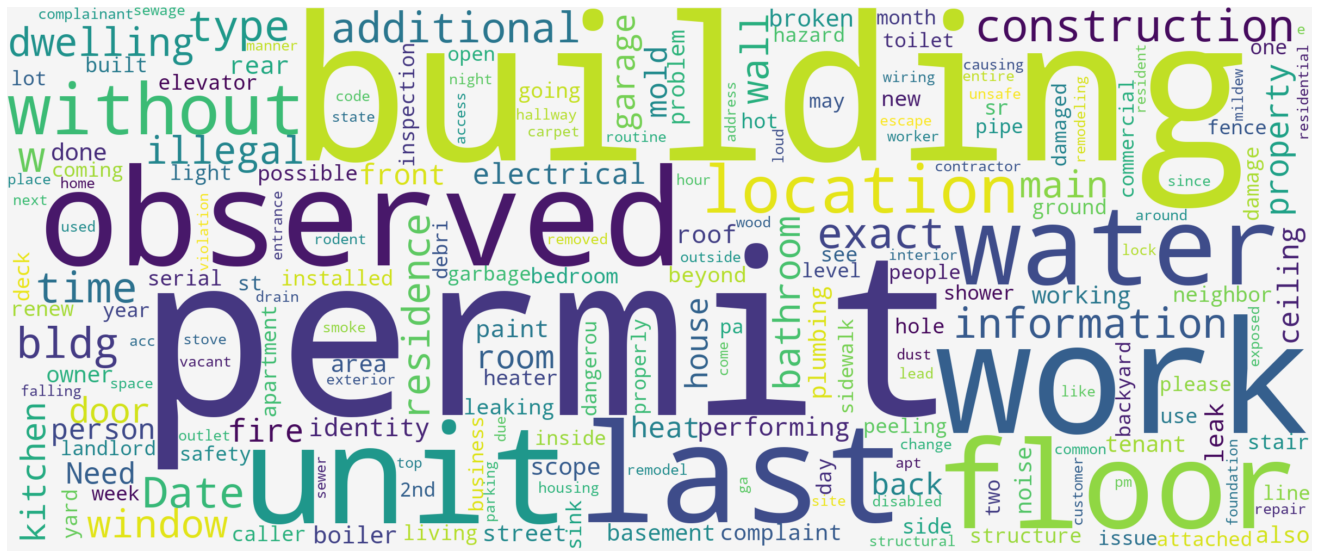

In [36]:
text = " ".join(complaint for complaint in df.complaint_description)
stop_words = stopwords.words('english')
wordcloud = WordCloud(stopwords=stop_words, background_color="whitesmoke",
                     collocations = False, width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


<h1>Most Common Word Pairs</h1>

<div class="description">
Next we'll create a wordcloud to show the most common word pairs that were found in the complaints.
</div>

(-0.5, 2399.5, 999.5, -0.5)

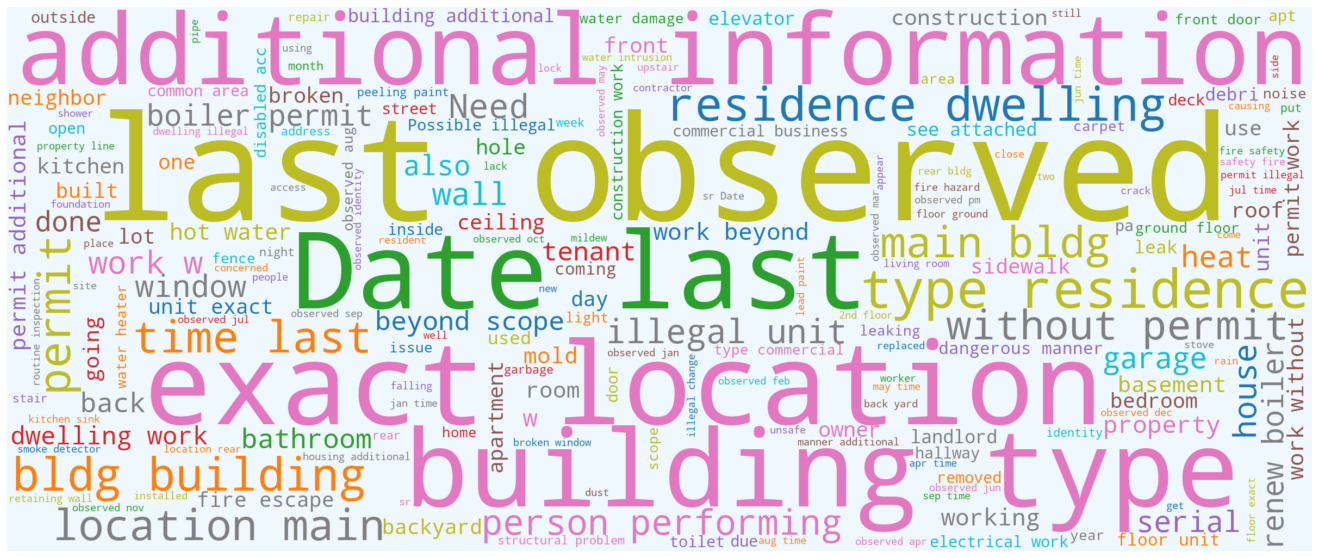

In [38]:
text = " ".join(complaint for complaint in df.complaint_description)
stop_words = stopwords.words('english')
wordcloud = WordCloud(stopwords=stop_words, background_color="aliceblue",
                     colormap = "tab10", width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

<div class="description">
Finally we will save the preprocessed data in our /data/ directory.
In the clean_data notebook we will create stemmed and lemmatized versions of 
the data before tokenizing it with Tensorflow's tokenizer. 
</div>

In [151]:
#finally we save the preprocessed data to our data subdirectory 
#next we will stem or lemmatize the text before tokenizing it via Tensorflow
preprocessed = df.copy()
preprocessed.to_csv(data_path + '/preprocessed.csv',index = False)